# 01. Dataset Creation

## Importing packages

In [1]:
import os
import csv

## Creating a `build_dataset()` function that puts together all the data from the BBC news raw dataset into a single csv file

In [2]:
parent_dir = "./bbc"
labels = ['business', 'entertainment', 'politics', 'sport', 'tech']
final_result = []


def build_dataset():
    for label in labels:
        directory = f"{parent_dir}/{label}"
        for text_file in os.listdir(directory):
            text_file_path = f"{directory}/{text_file}"
            with open(text_file_path, 'rb') as file:
                text = file.readlines()
                text = [word.decode('ISO-8859-1') for word in text]
                result = list(map(lambda string: string.replace('\n', ''), text))
                result = [word.lower() for words in result for word in words.split()]
                _dict = {'File_Name': text_file, 'Content': ' '.join(result), 'Category': label, 'Complete_Filename': f'{text_file}-{label}'}
                final_result.append(_dict)

    fields = ['File_Name', 'Content', 'Category', 'Complete_Filename']
    output_file = 'bbc_news_result.csv'
    with open(output_file, 'w') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames = fields) 
        writer.writeheader()
        writer.writerows(final_result)
    
    

## Invoking the `build_dataset()` function 

In [3]:
build_dataset()

# 02. Exploratory Data Analysis

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the dataset

In [5]:
bbc_df = pd.read_csv('bbc_news_result.csv')

In [6]:
bbc_df.head()

,File_Name,Content,Category,Complete_Filename
0,053.txt,weak dollar hits reuters revenues at media gro...,business,053.txt-business
1,055.txt,sa unveils 'more for all' budget the south afr...,business,055.txt-business
2,148.txt,alfa romeos 'to get gm engines' fiat is to sto...,business,148.txt-business
3,165.txt,consumer spending lifts us growth us economic ...,business,165.txt-business
4,039.txt,chinese wine tempts italy's illva italy's illv...,business,039.txt-business


## Visualizing the dataset

<AxesSubplot:title={'center':'A bar plot representing the number of articles in each category'}, xlabel='Number of articles', ylabel='Category'>

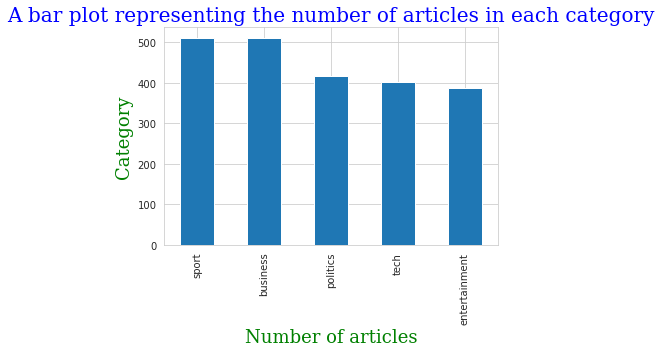

In [7]:
larger_font = {'family':'serif','color':'blue','size':20}
smaller_font = {'family':'serif','color':'green','size':18}

plt.title('A bar plot representing the number of articles in each category', **larger_font)
plt.xlabel('Number of articles', **smaller_font)
plt.ylabel('Category', **smaller_font)
plt.rcParams["figure.figsize"] = (20, 7)

bbc_df['Category'].value_counts().plot.bar()

### As can be seen from the histogram above, the dataset is balanced

## Categorizing the articles by length

Text(0.5, 1.0, 'News length distribution')

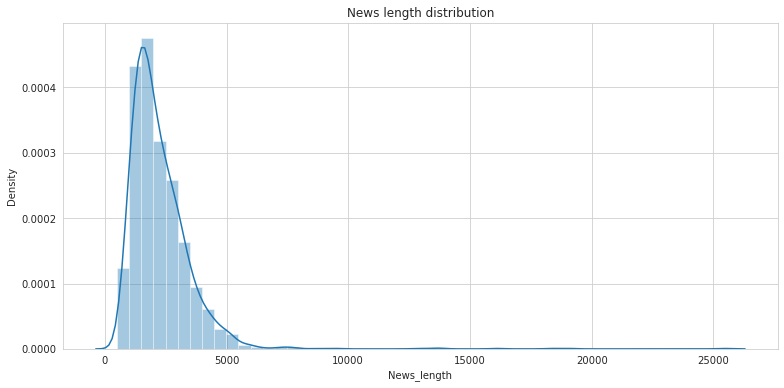

In [8]:
bbc_df['News_length'] = bbc_df['Content'].str.len()

plt.figure(figsize=(12.8,6))
sns.distplot(bbc_df['News_length']).set_title('News length distribution')

In [9]:
bbc_df['News_length'].describe()

count     2225.000000
mean      2259.863371
std       1360.920293
min        500.000000
25%       1443.000000
50%       1962.000000
75%       2797.000000
max      25427.000000
Name: News_length, dtype: float64

### Plotting a distribution plot from the 95% percentile of the dataset

Text(0.5, 1.0, 'News length distribution')

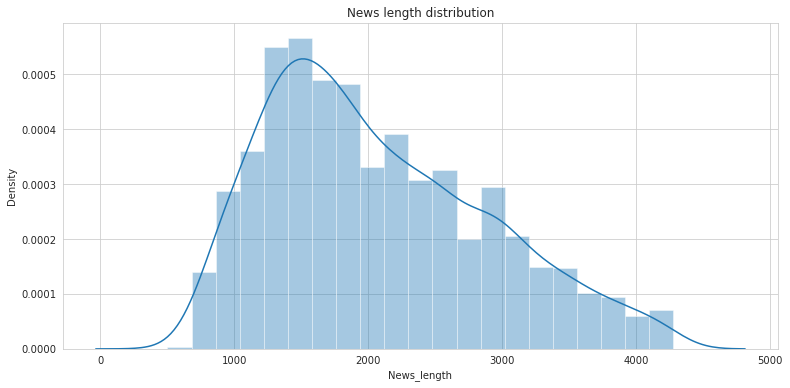

In [10]:
percentile_95 = bbc_df['News_length'].quantile(0.95)
bbc_df_95 = bbc_df[bbc_df['News_length'] < percentile_95]
plt.figure(figsize=(12.8,6))
sns.distplot(bbc_df_95['News_length']).set_title('News length distribution')

## Box plot representation of the dataset

<AxesSubplot:xlabel='Category', ylabel='News_length'>

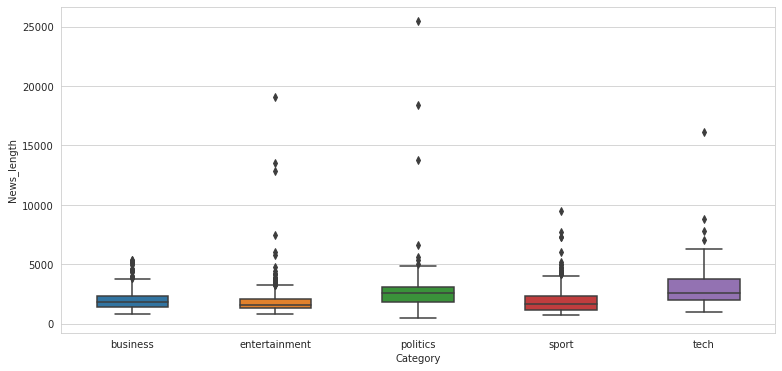

In [11]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=bbc_df, x='Category', y='News_length', width=.5)

<AxesSubplot:xlabel='Category', ylabel='News_length'>

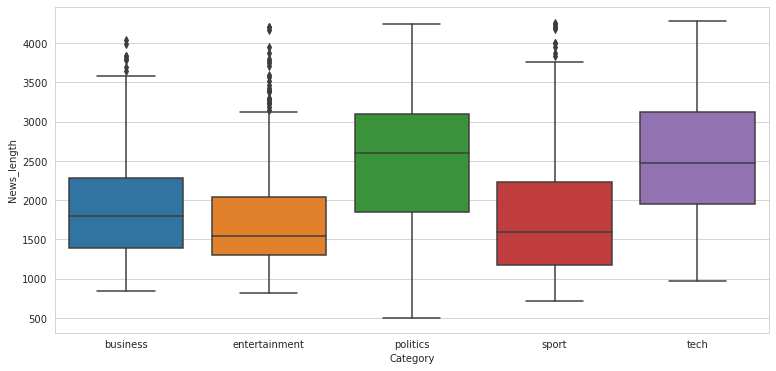

In [12]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=bbc_df_95, x='Category', y='News_length')

# 03. Feature Engineering

In [13]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np

In [14]:
bbc_df.head()

,File_Name,Content,Category,Complete_Filename,News_length
0,053.txt,weak dollar hits reuters revenues at media gro...,business,053.txt-business,1378
1,055.txt,sa unveils 'more for all' budget the south afr...,business,055.txt-business,2046
2,148.txt,alfa romeos 'to get gm engines' fiat is to sto...,business,148.txt-business,1473
3,165.txt,consumer spending lifts us growth us economic ...,business,165.txt-business,2170
4,039.txt,chinese wine tempts italy's illva italy's illv...,business,039.txt-business,1248


## 3.1 Text Cleaning and Preparation

### 3.1.1 Text Cleaning and Preparation

In [15]:
bbc_df['Parsed_Content'] = bbc_df['Content'].str.replace('"', '')

#### Removing punctuation marks

In [16]:
punctuation_marks = list("?:!.,;")

for punctuation in punctuation_marks:
    bbc_df['Parsed_Content'] = bbc_df['Parsed_Content'].str.replace(punctuation, '')

#### Removing possessive pronouns

In [17]:
bbc_df['Parsed_Content'] = bbc_df['Parsed_Content'].str.replace("'s", "")

### 3.1.2 Stemming and Lemmatization

In [18]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/gson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/gson/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [19]:
wordnet_lemmatizer = WordNetLemmatizer()

number_of_rows = len(bbc_df)
list_of_lemmatized_text = []

for row in range(0, number_of_rows):
    lemmatized_list = []
    text = bbc_df.loc[row]['Parsed_Content']
    text_words = text.split(" ")

    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    lemmatized_text = " ".join(lemmatized_list)
    
    list_of_lemmatized_text.append(lemmatized_text)

In [20]:
bbc_df['Parsed_Content'] = list_of_lemmatized_text

### 3.1.3 Stop Words

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
stop_words = list(stopwords.words('english'))

### Removing Stop Words

In [23]:
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    bbc_df['Parsed_Content'] = bbc_df['Parsed_Content'].str.replace(regex_stopword, '')

In [24]:
bbc_df['Parsed_Content'].head()

0    weak dollar hit reuters revenues  media group ...
1    sa unveil '  ' budget  south african governmen...
2    alfa romeos ' get gm engines' fiat   stop make...
3    consumer spend lift us growth us economic grow...
4    chinese wine tempt italy illva italy illva sar...
Name: Parsed_Content, dtype: object

## Creating wordclouds to better visualize the data

In [25]:
from wordcloud import WordCloud

### Sports

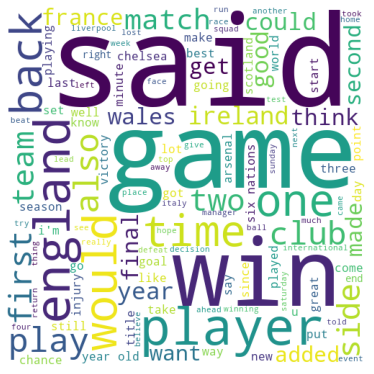

In [26]:
bbc_words = '' 
sport_df = bbc_df[bbc_df['Category'] == 'sport']


for words in sport_df['Content']: 
    tokens = words.split() 
    bbc_words += " ".join(tokens) + " "
    
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10,
                stopwords=stop_words).generate(bbc_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Politics

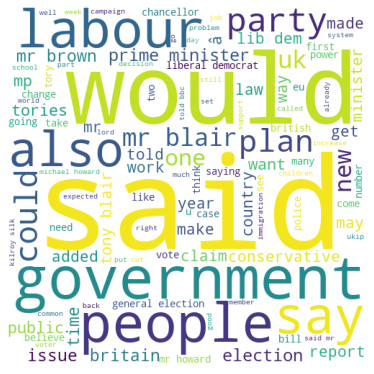

In [27]:
bbc_words = '' 
politics_df = bbc_df[bbc_df['Category'] == 'politics']

politics_df

for words in politics_df['Content']: 
    tokens = words.split() 
    bbc_words += " ".join(tokens) + " "

wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10,
                stopwords=stop_words).generate(bbc_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## 3.2 Label Encoding

In [28]:
category_codes = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}

In [29]:
# Category mapping
bbc_df['Category_Code'] = bbc_df['Category']
bbc_df = bbc_df.replace({'Category_Code':category_codes})

In [30]:
bbc_df.head()

,File_Name,Content,Category,Complete_Filename,News_length,Parsed_Content,Category_Code
0,053.txt,weak dollar hits reuters revenues at media gro...,business,053.txt-business,1378,weak dollar hit reuters revenues media group ...,0
1,055.txt,sa unveils 'more for all' budget the south afr...,business,055.txt-business,2046,sa unveil ' ' budget south african governmen...,0
2,148.txt,alfa romeos 'to get gm engines' fiat is to sto...,business,148.txt-business,1473,alfa romeos ' get gm engines' fiat stop make...,0
3,165.txt,consumer spending lifts us growth us economic ...,business,165.txt-business,2170,consumer spend lift us growth us economic grow...,0
4,039.txt,chinese wine tempts italy's illva italy's illv...,business,039.txt-business,1248,chinese wine tempt italy illva italy illva sar...,0


## 3.3 Train - Test split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(bbc_df['Parsed_Content'], 
                                                    bbc_df['Category_Code'], 
                                                    test_size=0.15, 
                                                    random_state=8)

## 3.4 Text Representation

In [32]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=(1, 2),
                        stop_words=None,
                        lowercase=False,
                        max_df=1.,
                        min_df=10,
                        max_features=300,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)



(1891, 300)
(334, 300)


In [33]:
for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print(f"# '{Product}' category:")
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")


# 'business' category:
  . Most correlated unigrams:
. profit
. economy
. oil
. growth
. bank
  . Most correlated bigrams:
. last year
. year old

# 'entertainment' category:
  . Most correlated unigrams:
. music
. tv
. star
. award
. film
  . Most correlated bigrams:
. mr blair
. prime minister

# 'politics' category:
  . Most correlated unigrams:
. minister
. blair
. election
. party
. labour
  . Most correlated bigrams:
. prime minister
. mr blair

# 'sport' category:
  . Most correlated unigrams:
. game
. club
. team
. cup
. match
  . Most correlated bigrams:
. say mr
. year old

# 'tech' category:
  . Most correlated unigrams:
. digital
. technology
. computer
. software
. users
  . Most correlated bigrams:
. year old
. say mr



# 4. Model Training

## Support Vector Machine (SVM)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit

### Cross-Validation for Hyperparameter tuning

In [35]:
first_svc = svm.SVC(random_state=8)

### Taking a look at the hyperparameters that we're gonna use

In [36]:
pprint(first_svc.get_params())

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


### Hyperparameters of concern (The ones that we are going to tune)

### `C`: Penalty parameter C of the error term.
### `kernel`: Specifies the kernel type to be used in the algorithm.
### `gamma`: Kernel coefficient.
### `degree`: Degree of the polynomial kernel function.

## Randomized Search Cross Validation

In [37]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


In [38]:
# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=SVC(random_state=8), n_iter=50,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   random_state=8, scoring='accuracy', verbose=1)

### Best hyperparameters resulting from the Random Search:

In [39]:
print(f"The best hyperparameters from Random Search are: \n{random_search.best_params_}\n")
print(f"The mean accuracy of a model with these hyperparameters is: \n{random_search.best_score_}\n")

The best hyperparameters from Random Search are: 
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is: 
0.9222725328905995



## Grid Search Cross Validation

In [40]:
# Create the parameter grid based on the results of random search 
C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

# Create a base model
svc = svm.SVC(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=SVC(random_state=8),
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear'],
                          'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1], 'degree': [3, 4, 5],
                          'kernel': ['poly'], 'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1],
                          'gamma': [1, 10, 100], 'kernel': ['rbf'],
                          'probability': [True]}],
             scoring='accuracy', verbose=1)

### Best hyperparameters for the Grid Search:

In [41]:
print(f"The best hyperparameters from Grid Search are: \n{grid_search.best_params_}\n")
print(f"The mean accuracy of a model with these hyperparameters is: \n{grid_search.best_score_}\n")

The best hyperparameters from Grid Search are: 
{'C': 0.1, 'kernel': 'linear', 'probability': True}

The mean accuracy of a model with these hyperparameters is: 
0.9488



# Saving the model

In [42]:
best_svc = grid_search.best_estimator_

In [43]:
best_svc

SVC(C=0.1, kernel='linear', probability=True, random_state=8)

# Model Fit and Performance

In [44]:
best_svc.fit(features_train, labels_train)

SVC(C=0.1, kernel='linear', probability=True, random_state=8)

## Predictions

In [45]:
svc_pred = best_svc.predict(features_test)

### Training accuracy

In [46]:
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))

The training accuracy is: 
0.9613960867265997


### Testing accuracy

In [47]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The test accuracy is: 
0.9341317365269461
